# Bounty: Sentiment Analysis with Python Project

## Data Acquisition

The data acquisition process is a critical initial step for any data science project. In my project, It involves fetching news articles related to a user-specified topic from the newsapi.org API. The process is as follows:

1. **User Input**: The user provides a topic of interest.
2. **API Request**: The script makes an HTTP GET request to the newsapi.org API, passing the topic and an API key as parameters.
3. **Response Handling**: The API's response is received in JSON format, from which we extract the articles.
4. **Data Validation**: If fewer than 10 articles are found for the given topic, the user is prompted to try a different topic, ensuring a robust dataset for analysis.
5. **Result Storage**: The fetched articles are stored in a list of dictionaries, each containing the description and publication date of an article.

In [1]:
import requests

def query_newsapi(topic, api_key):
    """
    Fetches news articles related to the given topic from the newsapi.org API.

    Parameters:
    topic (str): Topic to search for in news articles.
    api_key (str): API key for newsapi.org.

    Returns:
    list: A list of dictionaries containing articles' title, description, and published date.
    """
    print(f"Fetching news for topic: {topic}...")
    url = f'https://newsapi.org/v2/everything?q={topic}&sortBy=popularity&apiKey={api_key}'
    response = requests.get(url)
    data = response.json()
    articles = data.get('articles', [])
    print(f"Found {len(articles)} articles for topic: {topic}.")
    return [{'description': article['description'], 'publishedAt': article['publishedAt']} for article in articles]

api_key = 'f51eac6aca0c4e638302bbc4e304572d'
topic = input("Enter a topic to search news for: ")
if topic == '':
    topic = 'bitcoin' # default topic
article_details = query_newsapi(topic, api_key)
for article_detail in article_details:
    print(article_detail)

Fetching news for topic: bitcoin...
Found 100 articles for topic: bitcoin.
{'description': 'The last few years have been, to put it mildly, rough. And 2023 continued to bring sad tidings. Amid the humanitarian crisis that is the Palestine-Israeli conflict, plus increased fears around the credibility and reliability of AI and Elon Musk’s ongoing melt…', 'publishedAt': '2023-12-29T17:00:17Z'}
{'description': 'On Telegram, scammers are impersonating doctors to sell fake Covid-19 vaccination certificates and other products, showing how criminals are taking advantage of conspiracy theories.', 'publishedAt': '2023-12-18T12:00:00Z'}
{'description': 'Worldcoin, Sam Altman’s cryptocurrency venture, is now integrating its verification services into popular apps such as Reddit, Discord, Shopify, Mercado Libre, Telegram, and Minecraft. The move is part of Altman’s World ID 2.0, which describes itself as “a hu…', 'publishedAt': '2023-12-13T17:45:00Z'}
{'description': "Add to a charity haul that's a

## Data Cleaning and Translation

After acquiring the news articles, the next crucial step is to process the text data for sentiment analysis. This step involves cleaning and translating the content to ensure uniformity and accuracy in the analysis.

### Cleaning Process
The cleaning process includes several actions:
- **Lowercasing**: Converts all text to lowercase to standardize the text and avoid duplication of words based on case differences.
- **Punctuation Removal**: Strips all punctuation from the text, as it does not contribute to sentiment and can interfere with text processing.
- **Tokenization**: Splits the text into individual words or tokens. This step is essential for the removal of stopwords.
- **Stopwords Removal**: Eliminates common words like 'the', 'is', and 'in', which do not carry significant sentiment and are frequent across all types of text.

### Translation
Since the news articles may be in various languages, it's necessary to translate them into English to maintain consistency across the dataset:
- **Language Detection**: Identifies the language of each article using the `langdetect` library.
- **Translation**: Utilizes the `googletrans` library to translate non-English text to English.

### Code Implementation
The processing is implemented through two functions:
- `clean_and_translate`: Cleans and translates a single string of text.
- `process_data`: Iterates over all articles, applying the `clean_and_translate` function to the title and description of each article.

Here is a high-level overview of the functions which will be used:

- `clean_and_translate(text)`: Cleans and translates the given text to English if it's detected to be in another language.
- `process_data(articles)`: Processes a list of articles, cleaning and translating the titles and descriptions of each.

In [2]:
from langdetect import detect
from googletrans import Translator
import nltk
from nltk.corpus import stopwords
import string

# Initialize the Translator
translator = Translator()

def clean_and_translate(text):
    """
    Cleans and translates the text to English. It lowercases, removes punctuation,
    tokenizes, and removes stopwords. Translates non-English text to English.

    Parameters:
    text (str): Text to be processed.

    Returns:
    str: Processed and translated text.
    """
    if not text:
        return ""
    try:
        if detect(text) != 'en':
            text = translator.translate(text, dest='en').text
    except Exception as e:
        print(f"Translation error: {e}")
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

def process_data(articles):
    """
    Processes a list of articles by cleaning and translating their descriptions.

    Parameters:
    articles (list): A list of articles.

    Returns:
    list: Processed list of articles with cleaned and translated descriptions.
    """
    for article in articles:
        article['cleaned_description'] = clean_and_translate(article['description'])
    return articles

# Processing the articles
processed_articles = process_data(article_details)
for processed_article in processed_articles:
    print(processed_article)

{'description': 'The last few years have been, to put it mildly, rough. And 2023 continued to bring sad tidings. Amid the humanitarian crisis that is the Palestine-Israeli conflict, plus increased fears around the credibility and reliability of AI and Elon Musk’s ongoing melt…', 'publishedAt': '2023-12-29T17:00:17Z', 'cleaned_description': 'last years put mildly rough 2023 continued bring sad tidings amid humanitarian crisis palestineisraeli conflict plus increased fears around credibility reliability ai elon musk ’ ongoing melt…'}
{'description': 'On Telegram, scammers are impersonating doctors to sell fake Covid-19 vaccination certificates and other products, showing how criminals are taking advantage of conspiracy theories.', 'publishedAt': '2023-12-18T12:00:00Z', 'cleaned_description': 'telegram scammers impersonating doctors sell fake covid19 vaccination certificates products showing criminals taking advantage conspiracy theories'}
{'description': 'Worldcoin, Sam Altman’s cryptocu

## Sentiment Analysis
The sentiment analysis process involves:
- **Calculating Sentiment Polarity**: Using the TextBlob library, we compute the sentiment polarity for each article's description. Sentiment polarity is a float value ranging from -1 (very negative) to +1 (very positive).
- **Categorizing Sentiment**: Each sentiment score is categorized as 'positive', 'neutral', or 'negative'. This categorization is based on predefined thresholds (e.g., a polarity score above 0.1 is considered 'positive').

### Code Implementation
The implementation involves a function, `perform_sentiment_analysis`, which:
1. Analyzes the sentiment of each cleaned description.
2. Categorizes the sentiment based on the calculated score.
3. Converts the publication date to a datetime format.
4. Return the processed data with sentiment and date information.

In [3]:
from textblob import TextBlob
import pandas as pd

def analyze_sentiment(text):
    """Calculate the sentiment polarity of the given text using TextBlob."""
    return TextBlob(text).sentiment.polarity

def perform_sentiment_analysis(articles):
    """
    Perform sentiment analysis on the cleaned descriptions of articles and add publication dates.
    
    Parameters:
    articles (list of dict): A list of dictionaries that contains cleaned descriptions of articles and publication dates.
    
    Returns:
    list of dict: The list with updated articles including sentiment scores, categories, and publication dates.
    """
    print("Performing sentiment analysis...")
    for article in articles:
        # Analyze sentiment for description
        article['description_sentiment'] = analyze_sentiment(article['cleaned_description'])
        
        # Categorize sentiment for description
        article['description_sentiment_category'] = 'positive' if article['description_sentiment'] > 0.1 else 'negative' if article['description_sentiment'] < -0.1 else 'neutral'
        
        # Convert 'publishedAt' to datetime
        article['publishedAt'] = pd.to_datetime(article['publishedAt'])
    print("Finished performing sentiment analysis.")
    return articles

# Assuming 'article_details' contains the fetched articles with 'cleaned_description' and 'publishedAt'
sentiment_analysis_results = perform_sentiment_analysis(processed_articles)

# Create a DataFrame to view the sentiment analysis results along with publication dates
df_sentiments = pd.DataFrame(sentiment_analysis_results)
df_sentiments[['publishedAt', 'description', 'description_sentiment', 'description_sentiment_category']].head()

Performing sentiment analysis...
Finished performing sentiment analysis.


,publishedAt,description,description_sentiment,description_sentiment_category
0,2023-12-29 17:00:17+00:00,"The last few years have been, to put it mildly...",-0.200000,negative
1,2023-12-18 12:00:00+00:00,"On Telegram, scammers are impersonating doctor...",-0.500000,negative
2,2023-12-13 17:45:00+00:00,"Worldcoin, Sam Altman’s cryptocurrency venture...",0.600000,positive
3,2023-12-14 15:56:33+00:00,Add to a charity haul that's already raised ov...,0.000000,neutral
4,2023-12-08 19:41:47+00:00,Add to a charity haul that's already raised ov...,-0.166667,negative


## Step 4: Results Visualization
After processing and analyzing the sentiment of the news articles, visualizing the results can provide a clearer and more intuitive understanding of the data.

### Bar Chart: Sentiment Distribution Visualization
- The chart represents the count of each sentiment category from the column 'description_sentiment_category' as bars.
- The y-axis denotes the number of articles for each sentiment category.
- The x-axis displays the sentiment categories.

In [4]:
import plotly.express as px

# Sentiment Distribution Visualization
sentiment_distribution = df_sentiments['description_sentiment_category'].value_counts()
fig_distribution = px.bar(sentiment_distribution, 
                          title='Sentiment Distribution',
                          labels={'value': 'Number of Articles', 'index': 'Sentiment Category'},
                          color=sentiment_distribution.index)
fig_distribution.show()

### Line Chart: Sentiment Trend Over Time
The line chart will illustrate the average sentiment polarity over time, providing insights into how public sentiment towards a topic has evolved on a daily basis.

The y-axis represents the average sentiment polarity, with higher values indicating more positive sentiment.
The x-axis is time, showing the progression of sentiment over the dates articles were published.

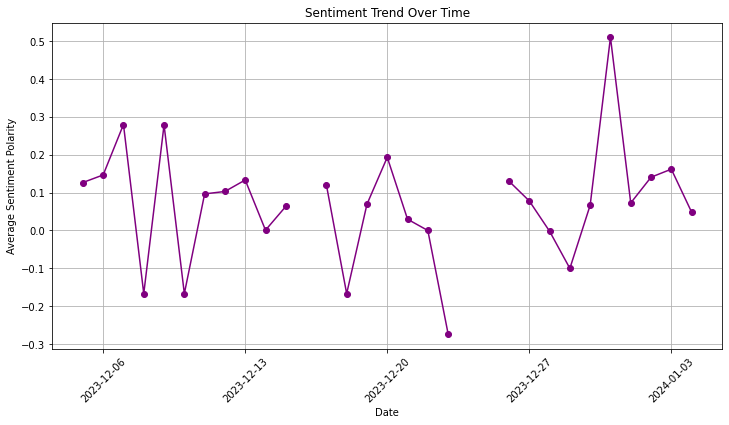

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Resampling data to get average sentiment per day
daily_sentiment = df_sentiments.resample('D', on='publishedAt').mean()
plt.figure(figsize=(12, 6))
plt.plot(daily_sentiment.index, daily_sentiment['description_sentiment'], marker='o', color='purple')
plt.title('Sentiment Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Polarity')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Scatter Plot: Sentiment Polarity vs. Subjectivity
The scatter plot will provide a visual comparison of sentiment polarity against subjectivity for each article description. The polarity measures how positive or negative the sentiment is, while subjectivity quantifies how much personal opinion versus factual information is contained in the text.

- Positive Sentiments: Shown in green, indicating articles with a more favorable tone.
- Neutral Sentiments: Shown in blue, representing articles with a balanced or unbiased tone.
- Negative Sentiments: Shown in red, highlighting articles with a more unfavorable tone.
This visualization helps to identify patterns and correlations between how subjective the articles are and the sentiment expressed.

In [6]:
def analyze_subjectivity(text):
    """Calculate the subjectivity of the given text using TextBlob."""
    return TextBlob(text).sentiment.subjectivity

# Add subjectivity analysis to the articles
for article in sentiment_analysis_results:
    article['description_subjectivity'] = analyze_subjectivity(article['cleaned_description'])

# Create a DataFrame
df_subjectivity = pd.DataFrame(sentiment_analysis_results)

# Scatter Plot
fig = px.scatter(df_subjectivity, x='description_sentiment', y='description_subjectivity', 
                 color='description_sentiment_category', title='Sentiment Polarity vs. Subjectivity')
fig.show()

## Final Project Summary
In this sentiment analysis project, I employed a sequence of functions to extract, process, analyze, and visualize sentiments from news articles. The project workflow was meticulously structured into several phases: data acquisition, data preprocessing, perform sentiment computation, and data visualization.

The `query_newsapi` function initiated the data acquisition, retrieving articles on a specified topic from newsapi.org. We extracted relevant details such as article descriptions, and publication dates.

During preprocessing, `clean_and_translate` function was pivotal in language detection and translation, ensuring the text was in English and normalized for consistency. This step was crucial for the accuracy of the subsequent sentiment analysis.

The `perform_sentiment_analysis` function computed sentiment scores for each article using TextBlob. Articles were categorized into positive, neutral, or negative sentiment classes based on their polarity scores.

Finally, visualizations were created using Plotly & Matplotlib. These visualizations offered an interactive and lucid portrayal of the results, allowing user to observe sentiment fluctuations over time and the balance between factual reporting and opinion.